In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    
import os
from utils import * 
from net import *

import torch.cuda
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR

weights_unet = '245.pth'
Unet = resnet_e(1,1).cuda()
Unet.load_state_dict(torch.load(weights_unet))


#Switch CUDA devices
torch.cuda.set_device(2)

In [11]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [12]:
# Load the training dataset
real_dataset = datasets.ImageFolder(root='/home/kiss2023/workspace/train_images')
alerted_easy_dataset = datasets.ImageFolder(root = '/home/kiss2023/workspace/train_altered-easy')
alerted_medium_dataset = datasets.ImageFolder(root = '/home/kiss2023/workspace/train_altered-medium')
alerted_hard_dataset = datasets.ImageFolder(root = '/home/kiss2023/workspace/train_altered-hard')

In [13]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, real_dataset, alerted_easy_dataset, alerted_medium_dataset, alerted_hard_dataset, transform=None):
        self.real_dataset = real_dataset
        self.alerted_easy_dataset = alerted_easy_dataset  
        self.alerted_medium_dataset = alerted_medium_dataset  
        self.alerted_hard_dataset = alerted_hard_dataset
        self.transform = transform
        
    def __getitem__(self,index):

        source_folder = random.choice(['alerted_easy', 'alerted_hard', 'alerted_medium'])

        if source_folder == 'alerted_easy':
            img0_tuple = random.choice(self.alerted_easy_dataset.imgs)
            # print(img0_tuple)
        elif source_folder == 'alerted_hard':
            img0_tuple = random.choice(self.alerted_hard_dataset.imgs)
            # print(img0_tuple)
        else:  # alerted_medium
            img0_tuple = random.choice(self.alerted_medium_dataset.imgs)
            # print(img0_tuple)

        #img0_tuple = random.choice(self.alerted_dataset.imgs)

        #We need to approximately 50% of images to be in the same class
        
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.real_dataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.real_dataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

    
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return max(len(self.alerted_easy_dataset.imgs), len(self.alerted_hard_dataset.imgs), len(self.alerted_medium_dataset.imgs))
     


# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((103,96)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(real_dataset= real_dataset, alerted_easy_dataset = alerted_easy_dataset, alerted_medium_dataset = alerted_medium_dataset, alerted_hard_dataset = alerted_hard_dataset,
                                        transform=transformation)


# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((103, 98)),  # Resize the images to a consistent size
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image pixel values
])


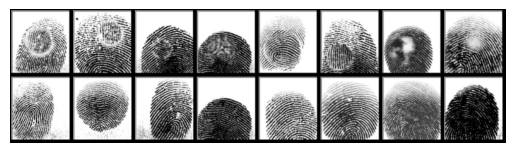

[1. 1. 1. 0. 1. 1. 1. 1.]


In [14]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 1x96x103 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same fingerprint, label is 0, same fingerpr in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [15]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            # Input: 1 x 96 x 103
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),  # Output: 64 x 96 x 103
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),  # Output: 64 x 95 x 102
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Output: 128 x 95 x 102
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 47 x 51

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Output: 256 x 47 x 51
            nn.ReLU(inplace=True)
            )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 47 * 51, 1024),  # Adjust the input size  # Output: 1024
            nn.ReLU(inplace=True),
    
            nn.Linear(1024, 256),  # Output: 256
            nn.ReLU(inplace=True),
    
            nn.Linear(256, 2)  # Output: 2
            )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
    
"""
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(pretrained=False)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is after avgpool layer)
        print(self.resnet)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        # print(self.resnet)

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        return output1, output2

"""

"\n#create the Siamese Neural Network\nclass SiameseNetwork(nn.Module):\n\n    def __init__(self):\n        super(SiameseNetwork, self).__init__()\n        # get resnet model\n        self.resnet = torchvision.models.resnet18(pretrained=False)\n\n        # over-write the first conv layer to be able to read MNIST images\n        # as resnet18 reads (3,x,x) where 3 is RGB channels\n        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel\n        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n        self.fc_in_features = self.resnet.fc.in_features\n        \n        # remove the last layer of resnet18 (linear layer which is after avgpool layer)\n        print(self.resnet)\n        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))\n        # print(self.resnet)\n\n        # add linear layers to compare between the features of the two images\n        self.fc = nn.Sequential(\n            nn.Linear(self.f

In [16]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [17]:
# Load the training dataset

GAMMA = 0.7
LR = 0.0005

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=16)


net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = LR)
#scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)

In [18]:
#TRAINING

counter = []
loss_history = [] 
iteration_number= 0
epochs = 10
#net.train()
Unet.cuda()

# Iterate throught the epochs
for epoch in range(epochs):
    

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()


        #Put altered image through U-Net
                ##Add Unet
        batch_size = img0.shape[0]
        img0 *= 255
        new_image0 = torch.ones(batch_size,1, 128, 128, dtype=torch.float32).cuda()
        new_image0 *= 255 
        new_image0[:,:, :img0.shape[2], :img0.shape[3]] = img0
        img0_out = Unet(new_image0)
        img0 = img0_out[:,:,:103,:96]
        min_val = torch.min(img0)
        max_val = torch.max(img0)
        img0 = (img0 - min_val) / (max_val - min_val)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        #scheduler.step()

        #torch.save(net.state_dict(), "SNN_Weights.pt")

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch+1}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())



show_plot(counter, loss_history)

Epoch number 1
 Current loss 2.4967265129089355



RuntimeError: CUDA out of memory. Tried to allocate 2.34 GiB (GPU 2; 23.70 GiB total capacity; 18.60 GiB already allocated; 716.56 MiB free; 21.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
real_dataset_test = datasets.ImageFolder(root="/home/kiss2023/workspace/test_images")
alerted_easy_dataset_test = datasets.ImageFolder(root="/home/kiss2023/workspace/test_altered-easy")
alerted_hard_dataset_test = datasets.ImageFolder(root="/home/kiss2023/workspace/Daniel/Siamese/data/dataset_MS2/test_altered-hard")
alerted_medium_dataset_test = datasets.ImageFolder(root="/home/kiss2023/workspace/test_altered-medium")

# Create the SiameseNetworkDataset for test data
siamese_dataset_test = SiameseNetworkDataset(real_dataset=real_dataset_test,
                                             alerted_easy_dataset=alerted_easy_dataset_test,
                                             alerted_hard_dataset=alerted_hard_dataset_test,
                                             alerted_medium_dataset=alerted_medium_dataset_test,
                                             transform=transformation)
test_dataloader = DataLoader(siamese_dataset_test, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, x1, label = next(dataiter)

#net.load_state_dict(torch.load( "SNN_UNet_Weights.pth"))

for i in range(10):
    # Iterate over 5 images and test them with the first image (x0)
    x0, x1, label2 = next(dataiter)
    x0 = x0.cuda()
    x1 = x1.cuda()
    
    #Put alerted through U-Net
    batch_size = img0.shape[0]
    img0 *= 255
    new_image0 = torch.ones(batch_size,1, 128, 128, dtype=torch.float32).cuda()
    new_image0 *= 255 
    new_image0[:,:, :img0.shape[2], :img0.shape[3]] = img0
    img0_out = Unet(new_image0)
    img0 = img0_out[:,:,:103,:96]
    min_val = torch.min(img0)
    max_val = torch.max(img0)
    img0 = (img0 - min_val) / (max_val - min_val)
    ####################################################
    
    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0).cpu()
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    
    euclidean_distance = F.pairwise_distance(output1, output2)

    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
    

In [ ]:
def calculate_accuracy(net, test_dataloader):
    correct_matches = 0
    total_images = 0

    for data in test_dataloader:
        x0, x1, label = data

        # Forward pass through the network
        output1, output2 = net(x0, x1)
        euclidean_distance = F.pairwise_distance(output1, output2)

        # Compare the predicted label with the ground truth label
        predicted_label = 0 if euclidean_distance.item() <= 0.8 else 1
        if predicted_label == label.item():
            correct_matches += 1

       
        total_images += 1

    accuracy = (correct_matches / total_images) * 100


    return accuracy

accuracy = calculate_accuracy(net, test_dataloader)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 97.33%
